201921034 장대호
프로젝트 개요:

학생들은 텍스트 데이터를 감성으로 분류하는 감성 분석 시스템을 개발합니다. 이 프로젝트는 전처리, 모델 선택, 학습, 평가 및 결과 시각화를 포함합니다.

1. 데이터:
    -자신의 학번이 홀수로 끝나는 학생은 amazon_uk_shoes_products_dataset_2021_12.csv를 짝수로 끝나는 학생은 wine_review.csv를 분석합니다.
    - 분석해야 하는 자료는 classroom repository에 있습니다.

In [1]:
%pip install pandas nltk

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [2]:
# NLTK 다운로드
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# 데이터 로드
df = pd.read_csv('wine_review.csv')

In [4]:
# 데이터 확인
print(df.head())
print(df.info())

                     id asins            brand  \
0  AV13ClKCGV-KLJ3akN68   NaN            Gallo   
1  AV13CsvW-jtxr-f38AQO   NaN  Fresh Craft Co.   
2  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
3  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
4  AV13CYL4-jtxr-f37_-t   NaN     Wine Cube153   

                                          categories             dateAdded  \
0  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:11Z   
1  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:42Z   
2  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
3  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
4  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:18Z   

            dateUpdated                                       descriptions  \
0  2018-01-10T18:06:28Z                                                NaN   
1  2018-01-10T05:38:33Z  [{"dateSeen":["2017-12-21T05:43:00.000Z","2017...

In [5]:
print(df.columns)

Index(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'descriptions', 'dimension', 'ean', 'flavors', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend',
       'reviews.id', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'sourceURLs', 'upc', 'weight'],
      dtype='object')


2. 데이터 전처리:
    - 데이터 정리 (노이즈 제거, 결측값 처리 등).
    - 텍스트 토큰화 및 불용어 제거.
    - 텍스트 정규화 (스테밍 또는 표제어 추출).

In [6]:
# 필요한 컬럼만 선택
df = df[['reviews.text', 'reviews.rating']]

# 결측값 처리: 리뷰 텍스트와 레이팅이 없는 행 제거
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# 텍스트 정리
def preprocess_text(text):
    text = text.lower() # 소문자 변환
    text = re.sub(r'[^a-zA-Z\s]', '', text) # 특수 문자 및 숫자 제거
    words = word_tokenize(text) # 단어 토큰화
    words = [word for word in words if word not in stopwords.words('english')] # 불용어 제거   
    lemmatizer = WordNetLemmatizer() # 텍스트 정규화 (표제어 추출)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# 데이터 전처리 적용
df['filtering_text'] = df['reviews.text'].apply(preprocess_text)

# 감성 데이터 전처리 다른 표현 방법
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# 데이터셋 분할
x = df['filtering_text']
y = df['sentiment']

# 전처리된 데이터를 새로운 csv 파일로 저장
df.to_csv('filtering_review.csv', index=False)

# 결측값 처리
df.dropna(subset=['filtering_text'], inplace=True)

In [7]:
# 데이터 로드
df = pd.read_csv('filtering_review.csv')
df.head()  # df의 처음 5개 행 출력해서 csv 파일 내용확인
print(df.columns)  # 컬럼 이름 확인

Index(['reviews.text', 'reviews.rating', 'filtering_text', 'sentiment'], dtype='object')


3. 모델 구현:
    - 수업에서 홯용한 모델을 적용

4. 모델 학습 및 튜닝:
    - 데이터셋을 학습 및 테스트 세트로 분할.
    - 모델 학습 및 하이퍼파라미터 튜닝 (예: 그리드 서치 또는 랜덤 서치 사용).
    - 교차 검증과 같은 기술을 사용하여 견고성 보장.

In [8]:
# 학습 세트와  테스트 세트 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# 파이프라인 설정
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

# 하이퍼파라미터 튜닝
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# 그리드서치로 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf'],
                         'tfidf__max_df': [0.8, 0.9, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

5. 모델 평가:
    - 정확도, 정밀도, 재현율, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 모델 평가.
    - 오버피팅과 언더피팅을 논의하고 이를 해결하는 방법 학습.

In [14]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)


In [15]:
# 모델 평가
print("Evaluation of the best model:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label='positive'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label='positive'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label='positive'):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Evaluation of the best model:
Best Parameters: {'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.93
Precision: 0.93
Recall: 1.00
F1 Score: 0.96

Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.06      0.11        53
    positive       0.93      1.00      0.96       681

    accuracy                           0.93       734
   macro avg       0.84      0.53      0.53       734
weighted avg       0.92      0.93      0.90       734



In [16]:
# 모델 평가 (교차 검증)
cross_val_scores = cross_val_score(best_model, x, y, cv=6, scoring='accuracy')
print("\nCross-validation evaluation:")
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean():.2f}")


Cross-validation evaluation:
Cross-validation scores: [0.92892157 0.92647059 0.92137592 0.92874693 0.92874693 0.92137592]
Mean cross-validation score: 0.93


6. 시각화 및 보고:
    - Matplotlib 또는 Seaborn과 같은 라이브러리를 사용하여 결과 시각화.
    - 혼동 행렬 및 ROC 곡선 생성.
    - 보고서에 결과 요약.

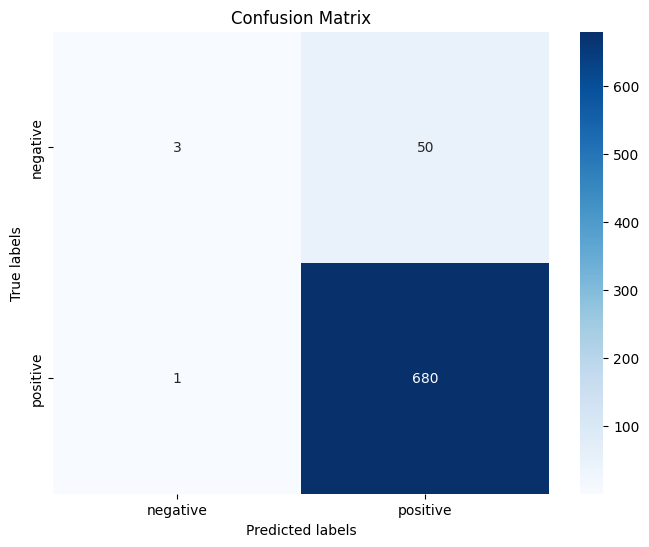

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성 및 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


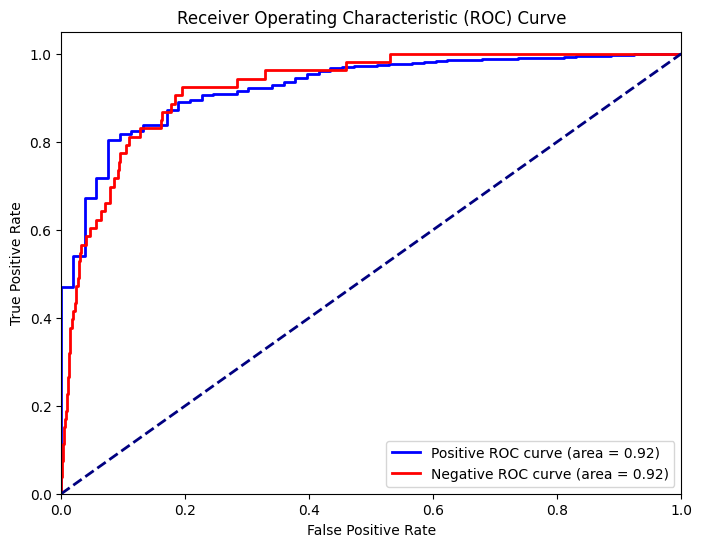

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 최적의 모델을 가져오기
best_model = grid_search.best_estimator_

# 예측 점수 계산
y_scores = best_model.decision_function(x_test)

# 긍정 및 부정 클래스의 ROC 곡선 계산
fpr, tpr, roc_auc = {}, {}, {}
for label in ['positive', 'negative']:
    y_test_binary = (y_test == label).astype(int)
    scores = y_scores if label == 'positive' else -y_scores
    fpr[label], tpr[label], _ = roc_curve(y_test_binary, scores)
    roc_auc[label] = auc(fpr[label], tpr[label])

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
for label, color in zip(['positive', 'negative'], ['blue', 'red']):
    plt.plot(fpr[label], tpr[label], lw=2, label=f'{label.capitalize()} ROC curve (area = {roc_auc[label]:.2f})', color=color)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()